
## Naive Bayes Model on KKBox's Music Recommendation System
In this notebook, we will fit a Naive bayes model to the data, calculate the accuracies and build evaluation metrics to validate how well our model fits the data.

In [28]:
from summary_fn import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import accuracy_score
import re
import random
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [29]:
# Import data
data = pd.read_csv('features_train_data.csv')

In [30]:
# Display the transpose of the rows to visualize all columns
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [31]:
display_all(data.head().T)

,0,1,2,3,4
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=
source_system_tab,explore,my library,my library,my library,explore
source_screen_name,Explore,Local playlist more,Local playlist more,Local playlist more,Explore
source_type,online-playlist,local-playlist,local-playlist,local-playlist,online-playlist
target,1,1,1,1,1
song_length,206471,284584,225396,255512,187802
artist_name,Bastille,Various Artists,Nas,Soundway,Brett Young
composer,Dan Smith| Mark Crew,NaN,N. Jones、W. Adams、J. Lordan、D. Ingle,Kwadwo Donkoh,Brett Young| Kelly Archer| Justin Ebach
lyricist,NaN,NaN,NaN,NaN,NaN


## 2. Data Processing 

#### 2.1 Data Normalization

We will convert few columns to percentage of total songs per user to normalize the data and improve the feature selection.

In [32]:
# Normalize data
hnorm_cols = ['msno_genre_count', 'source_system_tab_user_lev_c', 'source_screen_name_user_lev_c',
              'source_type_user_lev_c', 'composer_user_lev_c', 'lyricist_user_lev_c', 'artist_name_user_lev_c']

for i in hnorm_cols:
    data[i] = data[i]/data['msno_appear_count']

In [33]:
# Fill NA's before Normalization
data.gener_count = data.gener_count.fillna(-1)

In [34]:
# Drop less relevant columns
data.drop(columns=['lyricist_count_y', 'composer_count_x',
                   'gener_count'], inplace=True)

#### 2.2 Data Imputaion

Since we have a lot of data missing for few columns , we will replace continuous columns with -1 and categorical varaibles with 'NA' to treat them as features and levels.

In [35]:
# Impute continuous columns
na_continuous_col = ['msno_genre_count', 'source_system_tab_user_lev_c', 'source_screen_name_user_lev_c',
                     'source_type_user_lev_c', 'artist_name_user_lev_c', 'composer_user_lev_c',
                     'lyricist_user_lev_c']
for col in na_continuous_col:
    data[col] = data[col].fillna(-1)

In [36]:
# Impute categorical columns
data = data.fillna('NaN')

#### 2.3 Label encoding

In [37]:
# Label encoding for the categorical varaibles
from sklearn import preprocessing


def encoder(x_train):
    le = preprocessing.LabelEncoder()
    for column_name in x_train.columns:
        if x_train[column_name].dtype.name in ['category', 'object']:
            x_train[column_name] = le.fit_transform(
                x_train[column_name].astype(str))


# Encode the data
encoder(data)

#### 2.4 Remove Negative Values

In [38]:
for col in data.columns:
    data[col] = data[col].abs()

## 3. Model Fitting

#### 3.1 Train Test Split

In [39]:
# Features and target varaibles
X = data.drop(columns='target', axis=1)
y = data['target']

# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, test_size=0.2)

# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2)

In [40]:
import gc
del data
del X_train_all
del y_train_all
gc.collect()

8228

#### 3.2 Taking a small sample of data for our first fit

In [41]:
# Sampled data
idx = random.sample(range(0, X_train.shape[0]), 100000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

In [42]:
# Base line model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
m = MultinomialNB()
m.fit(X_train_sampled, y_train_sampled)
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.615


#### 3.3 Training on whole data

In [43]:
# Fit best model
m = MultinomialNB()
m.fit(X_train, y_train)
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.615


In [44]:
# Test accuracy
predicted = m.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.615


In [45]:
pd.DataFrame(predicted, columns=['MNB']).to_csv(
    'mnb_test_score.csv', index=False)

## 4. Evaluation Metric

#### 4.1 Prediction Score

In [19]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.60264913 0.62805118]
recall: [0.65408083 0.57526249]
fscore: [0.62731256 0.60049893]
support: [732119 743365]


#### 4.2 Confusion Matrix

Confusion matrix, without normalization
[[478865 253254]
 [315735 427630]]
Normalized confusion matrix
[[0.65 0.35]
 [0.42 0.58]]


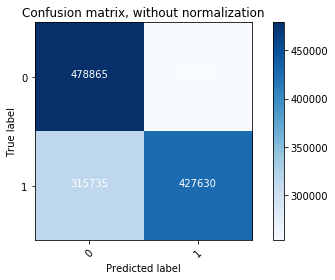

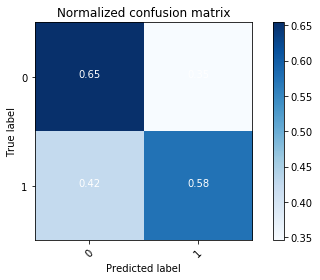

In [20]:
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0', '1']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [21]:
# Predict probability for ROC curve
predicted = m.predict_proba(X_test)

#### 4.3 ROC Curve

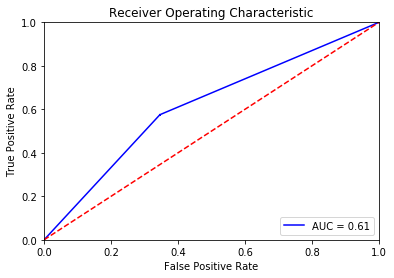

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, [i[1] for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate,
         'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()